In [1]:
# Import the necessary libraries and modules

import pandas as pd
import torchaudio
import torch
from torch.utils.data import Dataset, DataLoader
import os
import matplotlib.pyplot as plt
from IPython.display import Audio
import numpy as np
import pytorch_lightning as pl

from torch import Tensor
from pytorch_lightning.utilities.types import TRAIN_DATALOADERS, EVAL_DATALOADERS

In [3]:
class InsectData(Dataset):

    """
    Class to generate a dataset of insect sounds.
    """

    def __init__(self, data: pd.DataFrame, transform: torch.nn.Module, num_classes: int):
        self.data = data
        self.transform = transform
        self.num_classes = num_classes

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> tuple[Tensor, Tensor]:
        sample_meta = self.data.iloc[idx]
        data_path = sample_meta.data_path
        species = sample_meta.species
        class_id = sample_meta.class_ID
        file_name = sample_meta.file_name

        path = os.path.join(data_path, species, file_name)

        if not os.path.exists(path):
            raise FileNotFoundError(
                f'file not found: \'{path}\'.'
            )

        waveform, sample_rate = torchaudio.load(path)

        spectrogram: Tensor = self.transform(waveform[0, :])

        species_one_hot: Tensor = torch.nn.functional.one_hot(
            torch.as_tensor(class_id, dtype=torch.long),
            num_classes=self.num_classes)

        return spectrogram, species_one_hot


class InsectDatamodule(pl.LightningDataModule):
    def __init__(
            self,
            csv_paths: list[str] | str,
            n_fft: int = 256,
            hop_length: int = 128,
            batch_size: int = 8):
        super().__init__()

        self.batch_size = batch_size

        csv_paths = [csv_paths] if isinstance(csv_paths, str) else csv_paths

        csv_list = []

        for csv_path in csv_paths:
            if not os.path.exists(csv_path):
                raise FileNotFoundError(
                    f'`csv_path` does not exist: \'{csv_path}\'.'
                )

            csv = pd.read_csv(csv_path)
            data_path = csv_path.split('.csv')[0]
            csv['data_path'] = data_path

            csv_list.append(csv)

        csv = pd.concat(csv_list)

        self.class_IDs = sorted(csv.class_ID.unique())
        self.num_classes = len(self.class_IDs)

        if not os.path.exists(data_path):
            raise FileNotFoundError(
                f'`data_path` does not exist: \'{data_path}\'.'
            )

        self.csv = csv

        self.transform = torchaudio.transforms.Spectrogram(n_fft=n_fft, hop_length=hop_length)

    def train_dataloader(self) -> TRAIN_DATALOADERS:

        csv = self.csv[self.csv.data_set == 'train']

        data_set = InsectData(
            data=csv, transform=self.transform, num_classes=self.num_classes)

        return DataLoader(data_set, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self) -> EVAL_DATALOADERS:

        csv = self.csv[self.csv.data_set == 'validation']

        data_set = InsectData(
            data=csv, transform=self.transform, num_classes=self.num_classes)

        return DataLoader(data_set, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self) -> EVAL_DATALOADERS:

        csv = self.csv[self.csv.data_set == 'test']

        data_set = InsectData(
            data=csv, transform=self.transform, num_classes=self.num_classes)

        return DataLoader(data_set, batch_size=self.batch_size, shuffle=False)


In [8]:
test_path = '../data/Cicadidae/Azanicadazuluensis/Azanicadazuluensis_MHV%20935%20A.zuluensis%20Haga%20Haga%20%235.wav'

In [9]:
InsectData(test_path, 

TypeError: InsectData.__init__() missing 2 required positional arguments: 'transform' and 'num_classes'

In [4]:
datamodule = InsectDatamodule(csv_paths=['../data/Cicadidae.csv', '../data/Orthoptera.csv'])

In [5]:
train_dataloader = datamodule.train_dataloader()

In [6]:
for x, class_id in train_dataloader:
    print(class_id)

RuntimeError: stack expects each tensor to be equal size, but got [129, 2785] at entry 0 and [129, 3446] at entry 1

In [ ]:
x, class_id = datamodule.train_data[0]

In [ ]:
type(transform)

torchaudio.transforms._transforms.Spectrogram

In [7]:
sorted(datamodule.train_data.data.class_ID.unique())

AttributeError: 'InsectDatamodule' object has no attribute 'train_data'

In [ ]:
sample_meta = ids.train_csv.iloc[0]

In [ ]:
sample_meta

file_name             Platypleurasp10_MHV%20313%20P.sp10%20Die%20Koo...
species                                                 Platypleurasp10
class_ID                                                             24
data_set                                                          train
original_file_name           MHV%20313%20P.sp10%20Die%20Koo%20%236b.wav
Name: 1, dtype: object

In [ ]:
csv = pd.read_csv('../data/Cicadidae.csv')

In [ ]:
csv

,file_name,species,class_ID,data_set,original_file_name
0,Myopsaltamelanobasis_Myopsalta_melanobasis_Bri...,Myopsaltamelanobasis,9,test,Myopsalta_melanobasis_Brigalow.wav
1,Platypleurasp10_MHV%20313%20P.sp10%20Die%20Koo...,Platypleurasp10,24,train,MHV%20313%20P.sp10%20Die%20Koo%20%236b.wav
2,Platypleurasp13_MHV%201016%20P.sp13%20nr%20Han...,Platypleurasp13,27,validation,MHV%201016%20P.sp13%20nr%20Hankey.wav
3,Platypleuraintercapedinis_MHV%20952%20P.cf_.br...,Platypleuraintercapedinis,21,train,MHV%20952%20P.cf_.brunea%20Mtunzini%20%235.wav
4,Myopsaltaxerograsidia_Myopsalta_xerograsidia_L...,Myopsaltaxerograsidia,10,train,Myopsalta_xerograsidia_Laura_River.wav
...,...,...,...,...,...
183,Platypleurasp13_MHV%201487%20P.sp%2013%20nr%20...,Platypleurasp13,27,test,MHV%201487%20P.sp%2013%20nr%20Thornhill%20%231...
184,Platypleuracfcatenata_MHV%20607%20P.catenata%2...,Platypleuracfcatenata,15,test,MHV%20607%20P.catenata%2020km%20W%20Swellendam...
185,Platypleuracapensis_MHV%20277%20P.capensis%204...,Platypleuracapensis,14,train,MHV%20277%20P.capensis%204km%20W%20Die%20Dam%2...
186,Platypleuraintercapedinis_MHV%20948%20P.cf_.br...,Platypleuraintercapedinis,21,train,MHV%20948%20P.cf_.brunea%20Morning%20Sun%20Ran...


In [10]:
torchaudio.load('../data/Cicadidae/Azanicadazuluensis/Azanicadazuluensis_MHV%20935%20A.zuluensis%20Haga%20Haga%20%235.wav')

RuntimeError: Couldn't find appropriate backend to handle uri ../data/Cicadidae/Azanicadazuluensis/Azanicadazuluensis_MHV%20935%20A.zuluensis%20Haga%20Haga%20%235.wav and format None.

In [ ]:
waveform, sample_rate = torchaudio.load('../data/Cicadidae/Azanicadazuluensis/Azanicadazuluensis_MHV%20935%20A.zuluensis%20Haga%20Haga%20%235.wav')

RuntimeError: Couldn't find appropriate backend to handle uri ../data/Cicadidae/Azanicadazuluensis/Azanicadazuluensis_MHV%20935%20A.zuluensis%20Haga%20Haga%20%235.wav and format None.

In [ ]:
waveform.shape

torch.Size([1, 441000])

In [ ]:
def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)
    plt.show(block=False)

In [ ]:
transform = torchaudio.transforms.Spectrogram(n_fft=256, hop_length=128)
spectrogram = transform(waveform[0, :])

In [ ]:
spectrogram.shape

torch.Size([129, 3446])

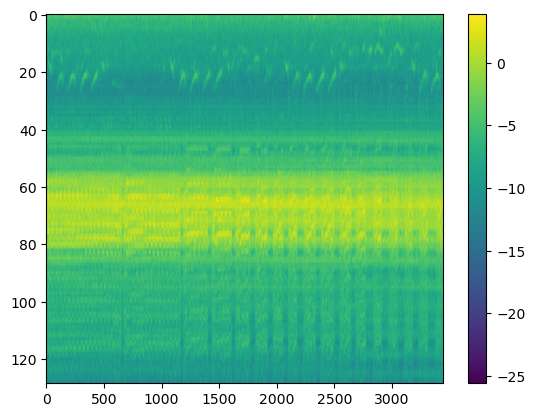

In [ ]:
plt.imshow(np.log(spectrogram), aspect='auto')
plt.colorbar()

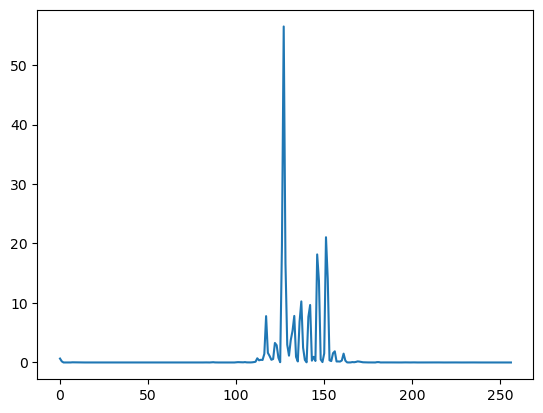

In [ ]:
plt.plot(spectrogram[:, 10])

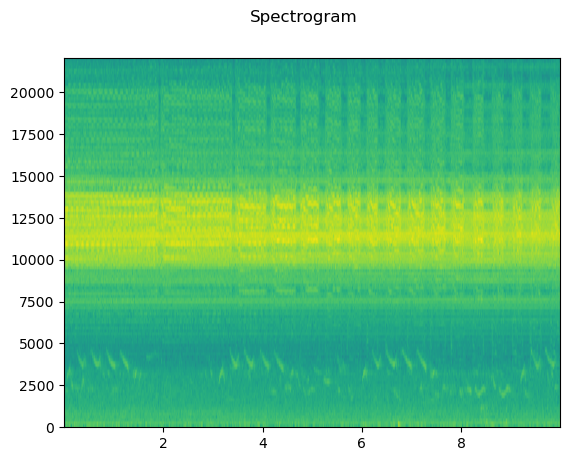

In [ ]:
plot_specgram(waveform=waveform, sample_rate=sample_rate)

In [ ]:
Audio(waveform.numpy()[0], rate=sample_rate)

In [ ]:
waveform.shape

torch.Size([1, 441000])

In [ ]:
waveform[0, :4410]

tensor([ 0.0080, -0.0356,  0.0076,  ..., -0.0406, -0.0138,  0.0576])

In [ ]:
waveform.reshape(1, 100, -1)[0, 0, :]

tensor([ 0.0080, -0.0356,  0.0076,  ..., -0.0406, -0.0138,  0.0576])